In [1]:
import numpy as np
from karabo.imaging.imager_oskar import OskarDirtyImager
from karabo.imaging import imager_wsclean
from karabo.simulation.interferometer import InterferometerSimulation
from karabo.simulation.observation import Observation
from karabo.simulation.sky_model import SkyModel
from karabo.simulation.telescope import Telescope
from karabo.simulation.visibility import Visibility
from karabo.imaging.imager_oskar import OskarDirtyImager, OskarDirtyImagerConfig
from karabo.simulator_backend import SimulatorBackend
from karabo_simutils import *
from astropy.io import fits
import matplotlib.pyplot as plt
import matplotlib as mpl
from datetime import datetime, timedelta
import xarray as xr
from matplotlib.colors import PowerNorm
from scipy.signal import convolve2d
import glob
from matplotlib.patches import Patch  
import sys
#mpl.use('Tkagg')
%matplotlib inline
from IPython.core.magic import register_cell_magic
@register_cell_magic
def skip(line, cell):
    return

## Simulation of Solar Model for Particle Acceleration Paper ##

In [2]:
start_frequency_hz_ = 100*1.e6  # noqa: F405
base_length_max = 60.e3
beam_size_arcsec = 3.e8/start_frequency_hz_/base_length_max*180/np.pi*3600
print('Maximum Baseline',base_length_max, 'Beam (arcsec)',beam_size_arcsec)
print("Frequency (MHz): ",start_frequency_hz_)
path = '/data/rohit/ska-solar-sim-repo-paper/sc3/run1/'
aa=fits.open(path+'20151203_240MHz_psimas.fits')
ms_filename = path+"solar0.ms"
vis_filename = path+"solar0.vis"
write_sm = True
tb_cut = 0.1 # 10% of max
ra_sun_center=249.141666667;dec_sun_center=21.986 #16 34 34.52 -21 59 09.7
if(write_sm):
    solar_map=aa[0].data
    sol_npix = len(np.where(solar_map>tb_cut*np.max(solar_map))[0])
    solar_map_jy=solar_map/np.nanmax(solar_map)*20*1.e4*(start_frequency_hz_/2.4e8)**1 / sol_npix
    ra_grid,dec_grid=np.meshgrid((np.arange(256)-128)*22.5/3600.,(np.arange(256)-128)*22.5/3600.)
    ra_grid=ra_grid+ra_sun_center;dec_grid=dec_grid+dec_sun_center
    idx=np.where(solar_map>tb_cut*np.nanmax(solar_map))
    sky_model_ra=ra_grid[idx];sky_model_dec=dec_grid[idx];flux=solar_map_jy[idx]
    # Simulation starts 
    sky_data = np.array([sky_model_ra, sky_model_dec, flux,np.zeros(len(flux)), \
        np.zeros(len(flux)),np.zeros(len(flux)), np.zeros(len(flux)),np.zeros(len(flux)), \
    np.zeros(len(flux)),np.zeros(len(flux)), np.zeros(len(flux)),np.zeros(len(flux))]).T
    sky_data=sky_data[0:16000,:]
    # Add Point Soure
    random_points = 0
    point_source_bool = 1
    size_=1000
    add_source = np.zeros((size_,12))
    point_flux = 0.1e4
    if(point_source_bool):
        add_source[0][0] = ra_sun_center + 0.2 # RA in deg
        add_source[0][1] = dec_sun_center + 0.2 # DEC in deg
        add_source[0][2] = point_flux # Flux
        sky_data1 = np.vstack((sky_data,add_source))
    else:
        sky_data1 = sky_data
    print('Maximum flux density (SFU):',sky_data1[:,2].max()/1.e4)
    print('Number of Sources:',len(sky_data1))
    np.savetxt(path+"source_point0.txt", sky_data1.T)

Maximum Baseline 60000.0 Beam (arcsec) 10.31324031235482
Frequency (MHz):  100000000.0
Maximum flux density (SFU): 0.1
Number of Sources: 9063


In [3]:
#telescope_path = '/media/rohit/sdata/ska-solar-files/meerkat.tm'
#telescope_path = '/data/rohit/skao_repo/ska1mid.tm'
#telescope_path = '/data/rohit/skao_repo/ska-mid-AAstar.tm'
#telescope_path = '/data/rohit/skao_repo/ska-mid-AA2.tm'
#telescope_path = '/data/rohit/skao_repo/ska-mid-AA1.tm'
#telescope_path = '/media/rohit/sdata/ska-solar-files/mwa.phase1.tm'
telescope_path = '/data/rohit/skao_repo/ska1low.tm'
telescope_name= 'ska-low'
hour_=0
minutes_=1
noise_enable_ = False
enable_array_beam=False
skao_repo_tel_path = '/data/rohit/skao_repo/'
#tel_all = get_telescope(skao_repo_tel_path) # 0 is SKA, and 1 is SKA-precursor
telescope_list = ['AA1','AA2','AAs','AA4','mwa']
telescope_path_list = ['/data/rohit/skao_repo/ska-low-AA1.tm','/data/rohit/skao_repo/ska-low-AA2.tm','/data/rohit/skao_repo/ska-low-AAstar.tm','/data/rohit/skao_repo/ska1low.tm','/data/rohit/skao_repo/mwa.phase1.tm']
#ska_aa_list = ['AA2','AAs','AA4']
#mid_bands=['1','3']
nt=1; tel = telescope_list[nt] # Put in your telescope in `tel`

#---------
sky_data1 = np.loadtxt(path+'source_point0.txt')
# skymodel_path='/data/rohit/solar-sky-models/solar_image_model.fits'
# #skymodel_path='/data/rohit/solar-sky-models/mark_skymodels/muram_560000_los0_grff.ncdf'
# path = '/data/rohit/ska-solar-sim-repo-paper/sc1/run3/'

# ra_sun_center=249.141666667;dec_sun_center=21.986 #16 34 34.52 -21 59 09.7
# skymodel_cellsize=22.5 # in arcsec
smdelt = 22.5 # in arcsec
smdata1, smhead1 = fits.getdata(path+'20151203_240MHz_psimas.fits',header=True)
# rand_arr = sky_data1[2,-100:-1]
# rand_ra_arr = sky_data1[0,-100:-1]
# rand_dec_arr = sky_data1[1,-100:-1]
# print()
# rand_ra_pix = 128 + (rand_ra_arr-ra_sun_center)/(22.5/3600.)
# rand_ra_pix = rand_ra_pix.astype(int)
# rand_dec_pix = 128 + (rand_dec_arr-dec_sun_center)/(22.5/3600.)
# rand_dec_pix = rand_dec_pix.astype(int)

Number of Baselines: 46971
Maximum Baseline 65369.411807052384


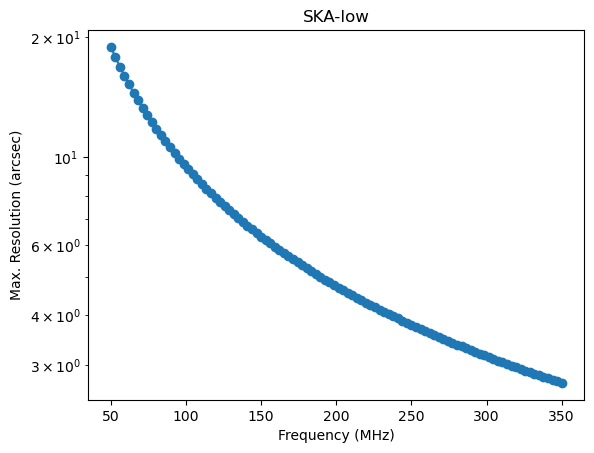

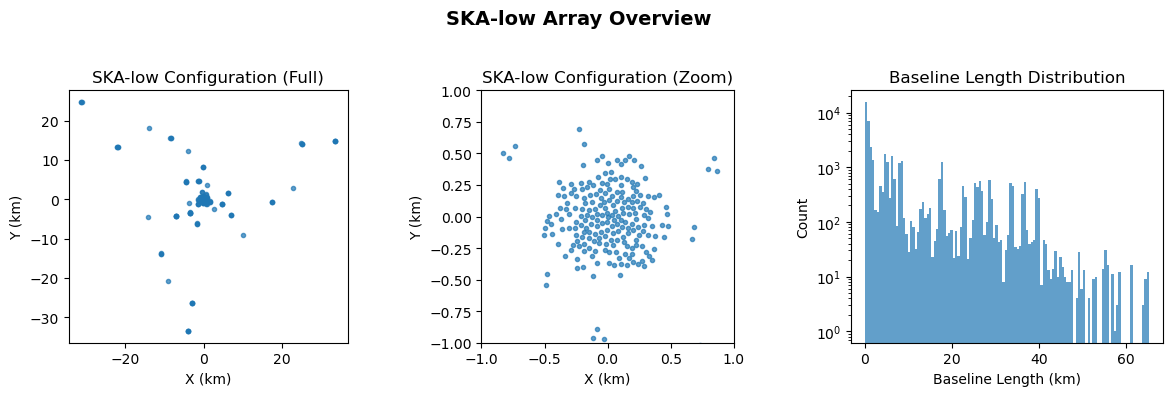

In [4]:
# Step-2 Analyse Telescope Model 
layout=np.loadtxt(telescope_path_list[2]+'/layout.txt')
nant=len(layout)
nb=int(nant*(nant-1)*0.5)
print('Number of Baselines:',nb)
base_length=[0]*nb
k=0
for i in range(nant):
    for j in range(i,nant):
        if(i!=j):
            base_length[k] = np.sqrt((layout[i][0]-layout[j][0])**2 + (layout[i][1]-layout[j][1])**2)
            k=k+1
base_length=np.array(base_length)
print('Maximum Baseline',base_length.max())
#----------------------------
freq_list0 = np.linspace(0.5,3.5,100)*100 # in MHz
beamsize_arr = 3.e8/base_length.max()/(freq_list0*1.e6)
beamsize_arr_arcsec = beamsize_arr*180/np.pi*3600
f,ax=plt.subplots(1,1)
ax.plot(freq_list0,beamsize_arr_arcsec,'o-')
ax.set_xlabel('Frequency (MHz)')
ax.set_ylabel('Max. Resolution (arcsec)')
ax.set_title('SKA-low')
ax.set_yscale('log')
plt.show()


#-----------------------------------------------------
fig, (ax0, ax1, ax2) = plt.subplots(1, 3, figsize=(12, 4))
# --- Panel 1: Full SKA-mid layout ---
for ax in [ax0, ax1]:
    ax.plot(layout[:, 0] / 1e3, layout[:, 1] / 1e3, 'o', ms=3, alpha=0.7)
    ax.set_xlabel('X (km)')
    ax.set_ylabel('Y (km)')
    ax.set_aspect('equal')
ax0.set_title('SKA-low Configuration (Full)')
ax1.set_title('SKA-low Configuration (Zoom)')
ax1.set_xlim(-1, 1)
ax1.set_ylim(-1, 1)
# --- Panel 3: Baseline length distribution ---
ax2.hist(base_length / 1e3, bins=120, color='tab:blue', alpha=0.7)
ax2.set_xlabel('Baseline Length (km)')
ax2.set_ylabel('Count')
ax2.set_yscale('log')
ax2.set_title('Baseline Length Distribution')
# Improve layout and appearance
fig.suptitle('SKA-low Array Overview', fontsize=14, fontweight='bold')
fig.tight_layout(rect=[0, 0, 1, 0.95])


In [5]:

j=0
freq_list=[start_frequency_hz_]
sol_npix = len(np.where(smdata1>tb_cut*np.max(smdata1))[0])
solar_map_jy = smdata1/np.nanmax(smdata1)*20*1.e4*(start_frequency_hz_/2.4e8)**1 / sol_npix
solar_map_all = solar_map_jy# np.hstack((solar_map_jy.flatten()))
#freq_list = [100,500,1500,3000]
# start_frequency_hz_ = freq_list[i]*1.e6
# beam_size_arcsec = 10
# flux_cutoff = 0 # high freq cut-off

# print('Beam (arcsec)',beam_size_arcsec)
# print("Frequency (MHz): ",start_frequency_hz_)
# ms_filename = path+"solar_"+"freq_"+str(int(freq_list[i]))+'_'+telescope_name+".ms"
# vis_filename = path+"solar_"+"freq_"+str(int(freq_list[i]))+'_'+telescope_name+".vis"
# solar_map=smdata1
# solar_map_jy=solar_map/np.nanmax(solar_map)*20*1.e4*(start_frequency_hz_/2.4e8)**1
# ra_sun_center=249.141666667;dec_sun_center=21.986 #16 34 34.52 -21 59 09.7
# ra_arr=(np.arange(solar_map_jy.shape[0])-int(solar_map_jy.shape[0]/2))
# dec_arr=(np.arange(solar_map_jy.shape[0])-int(solar_map_jy.shape[0]/2))
# print('Resolution: ',smhead1['CDELT1']*3600,' arcsec')
# ra_grid,dec_grid=np.meshgrid(ra_arr*smhead1['CDELT1'],dec_arr*smhead1['CDELT2'])
# ra_grid=ra_grid+ra_sun_center;dec_grid=dec_grid+dec_sun_center
# #solar_map_jy[solar_map_jy > flux_cutoff] = 0 # only 2-D
# solar_map_jy = solar_map_jy/np.nanmax(solar_map_jy)
# flux=solar_map_jy.flatten()
# #flux = [x for x in flux if x != 0]
# #flux = flux0[flux0 > flux_cutoff]
# sky_model_ra = ra_grid[solar_map_jy > flux_cutoff] # 1-D array
# sky_model_dec = dec_grid[solar_map_jy > flux_cutoff]
# sky_model_ra=ra_grid.flatten();sky_model_dec=dec_grid.flatten()
# print('Shape: ',smhead1['CDELT1'],smhead1['CUNIT1'],sky_model_ra)
# print(ra_grid.shape,len(flux),sky_model_ra[np.where(flux>0)].shape)



In [43]:
ms_filename = [0]*len(telescope_list)
vis_filename = [0]*len(telescope_list)
for i in range(len(telescope_list)):
    telescope_name=telescope_list[i]
    print(telescope_name)
    ms_filename[i] = path+"solar_"+"freq_100MHz_"+telescope_name+".ms"
    vis_filename[i] = path+"solar_"+"freq_100MHz_"+telescope_name+".vis"# Simulation starts 
    sky = SkyModel()
    ntchan = 1
    nchan = 1
    sky.add_point_sources(sky_data1.T)
    noise_enable_ = False
    enable_array_beam = False
    dtime=datetime(2000, 1, 1, 4, 0, 00, 0) # MWA / SKA-low
    backend=SimulatorBackend.OSKAR
    #telescope = Telescope.constructor(telescope_name, backend=backend)
    telescope=Telescope.read_OSKAR_tm_file(telescope_path_list[i])
    telescope.read_OSKAR_tm_file(telescope_path_list[i])
    print('Simulating Now..')
    simulation = InterferometerSimulation(vis_path=vis_filename[i], ms_file_path=ms_filename[i],
        channel_bandwidth_hz=40.e3, time_average_sec=1, noise_enable=noise_enable_, use_gpus=False,
        noise_seed="time", noise_freq="Range", noise_rms="Range", 
        noise_start_freq=1.e9, noise_inc_freq=1.e8, noise_number_freq=24, 
        noise_rms_start=0, noise_rms_end=0, enable_numerical_beam=enable_array_beam,
        enable_array_beam=enable_array_beam) 
    observation = Observation(mode='Tracking',phase_centre_ra_deg=ra_sun_center, start_date_and_time=dtime, 
        length=timedelta(hours=hour_, minutes=minutes_, seconds=0, milliseconds=0), 
        phase_centre_dec_deg=dec_sun_center, number_of_time_steps=ntchan, 
        start_frequency_hz=start_frequency_hz_, frequency_increment_hz=1, 
        number_of_channels=nchan,) 
    visibility = simulation.run_simulation(telescope, sky, observation, backend=backend)


AA1
Simulating Now..
Saved visibility to /data/rohit/ska-solar-sim-repo-paper/sc3/run1/solar_freq_100MHz_AA1.vis
AA2
Simulating Now..
Saved visibility to /data/rohit/ska-solar-sim-repo-paper/sc3/run1/solar_freq_100MHz_AA2.vis
AAs
Simulating Now..
Saved visibility to /data/rohit/ska-solar-sim-repo-paper/sc3/run1/solar_freq_100MHz_AAs.vis
AA4
Simulating Now..
Saved visibility to /data/rohit/ska-solar-sim-repo-paper/sc3/run1/solar_freq_100MHz_AA4.vis
mwa
Simulating Now..
Saved visibility to /data/rohit/ska-solar-sim-repo-paper/sc3/run1/solar_freq_100MHz_mwa.vis


In [44]:

mapsun=[0]*len(telescope_list)
DR0=[0]*len(telescope_list)
imgsize=4096
cellsize_arcsec=1.2*2 #beam_size_arcsec/npix_per_beam
cellsize_rad=cellsize_arcsec/3600*np.pi/180 # in rad
print('Cellsize:',cellsize_arcsec,'Beam (arcsec):',beam_size_arcsec,'Max length:')
print('Field of View (deg):',imgsize*cellsize_arcsec/3600.)
for i in range(len(telescope_list)):
    telescope_name=telescope_list[i]
    ms_filename_ = ms_filename[i]
    print(ms_filename_)
    dirty_imager = OskarDirtyImager(
        OskarDirtyImagerConfig(
            imaging_npixel=imgsize,
            imaging_cellsize=cellsize_rad,
        ))
    dirty_oskar_img = path+"solar_"+"freq_"+str(int(freq_list[j]))+'_'+telescope_name+"_oskar.fits"
    dirty_image = dirty_imager.create_dirty_image(visibility,output_fits_path=dirty_oskar_img)
    dirty_wsclean_img = path+"solar_"+"freq_"+str(int(freq_list[j]))+'_'+telescope_name+"_wsclean.fits"
    img_cmd = 'wsclean \
            -size '+str(imgsize)+' '+str(imgsize)+' \
            -name '+dirty_wsclean_img+' \
            -scale '+str(cellsize_rad)+'rad \
            -weight uniform\
            -maxuv-l 20000 -minuv-l 2\
            -mgain 0.8 -niter 4000 -auto-threshold 3 \
            -channels-out '+str(nchan)+' '+ms_filename_
    print(img_cmd)
    #-multiscale -scale 32amin
    try:
        restored = imager_wsclean.create_image_custom_command(command=img_cmd)
    except:
        pass # doing nothing on exception   
    

Cellsize: 2.4 Beam (arcsec): 10.31324031235482 Max length:
Field of View (deg): 2.7306666666666666
/data/rohit/ska-solar-sim-repo-paper/sc3/run1/solar_freq_100MHz_AA1.ms


/home/rohit/miniconda3/envs/karabo/lib/python3.9/site-packages/karabo/imaging/image.py:119: UserWarning: Received 3D data for image object.
                Will assume the 3 axes correspond to
                (polarisations, pixels_x, pixels_y).
                Inserting 1 additional axis for frequencies.
  warnings.warn(


wsclean             -size 4096 4096             -name /data/rohit/ska-solar-sim-repo-paper/sc3/run1/solar_freq_100000000_AA1_wsclean.fits             -scale 1.1635528346628863e-05rad             -weight uniform            -maxuv-l 20000 -minuv-l 2            -mgain 0.8 -niter 4000 -auto-threshold 3             -channels-out 1 /data/rohit/ska-solar-sim-repo-paper/sc3/run1/solar_freq_100MHz_AA1.ms
Creating /tmp/karabo-STM-rohit-TRnaSBphUX/WSClean-custom-CYB8jJ6dMI for Disk cache for WSClean custom command images
WSClean command: [cd /tmp/karabo-STM-rohit-TRnaSBphUX/WSClean-custom-CYB8jJ6dMI && OPENBLAS_NUM_THREADS=1 wsclean             -size 4096 4096             -name /data/rohit/ska-solar-sim-repo-paper/sc3/run1/solar_freq_100000000_AA1_wsclean.fits             -scale 1.1635528346628863e-05rad             -weight uniform            -maxuv-l 20000 -minuv-l 2            -mgain 0.8 -niter 4000 -auto-threshold 3             -channels-out 1 /data/rohit/ska-solar-sim-repo-paper/sc3/run1/sola

4205.5957
1000.0
1218.6217
1000.0
1028.645
1000.0
1041.8368
1000.0
1766.2684
1000.0


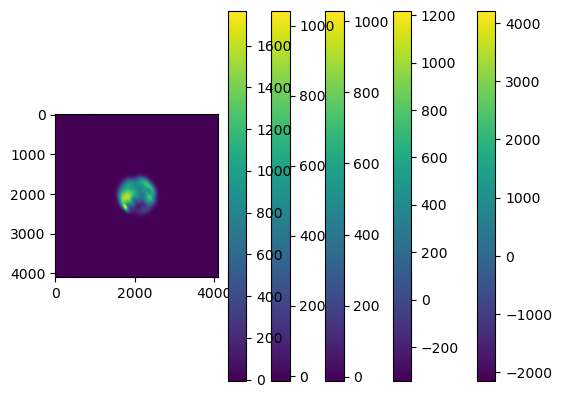

In [7]:
maplist = sorted(glob.glob('/data/rohit/ska-solar-sim-repo-paper/sc3/run1/*image.fits'))
mapsun=[0]*len(maplist)
DR0 = [0]*len(maplist)
for i in range(len(maplist)):
    mapsun0, head = fits.getdata(maplist[i],header=True)
    print(mapsun0.max())
    plt.imshow(mapsun0[0][0]);plt.colorbar()
    mapsun0 =  mapsun0[0][0]/np.max(mapsun0) * np.max(sky_data1[2])
    mapsun[i] = mapsun0[:,::-1]
    DR0[i] = np.max(mapsun[i])/np.std(mapsun[i][0:1024,0:1024])
    print(mapsun0.max())


In [8]:
print(sky_data1[2].max())
mapsun = np.array(mapsun)
print(mapsun.shape)
for k in range(5):
    print(mapsun[k].max()/np.std(mapsun[k][0:1024,0:1024]))
    print(mapsun[k].max(),np.std(mapsun[k][3500:4000,3500:4000]),np.std(mapsun[k]))
print(DR0)
print(np.max(mapsun,axis=(1,2)))

1000.0
(5, 4096, 4096)
7.1385684
1000.0 67.166504 287.24008
84.87336
1000.0 9.462603 63.458263
2450.1868
1000.0 0.38585758 6.167094
1420.7445
1000.0 0.5938059 9.353942
2231.44
1000.0 0.4243237 101.39294
[7.1385684, 84.87336, 2450.1868, 1420.7445, 2231.44]
[1000. 1000. 1000. 1000. 1000.]


SIMPLE  =                    T / Written by IDL:  Tue Apr 18 09:31:36 2023      BITPIX  =                  -64 / Number of bits per data pixel                  NAXIS   =                    2 / Number of data axes                            NAXIS1  =                  256 /                                                NAXIS2  =                  256 /                                                EXTEND  =                    T / FITS data may contain extensions               DATE    = '2023-04-18'         / Creation UTC (CCCC-MM-DD) date of FITS header  COMMENT FITS (Flexible Image Transport System) format is defined in 'Astronomy  COMMENT and Astrophysics', volume 376, page 359; bibcode 2001A&A...376..359H    END                                                                                                                                                                                                                                                                                     

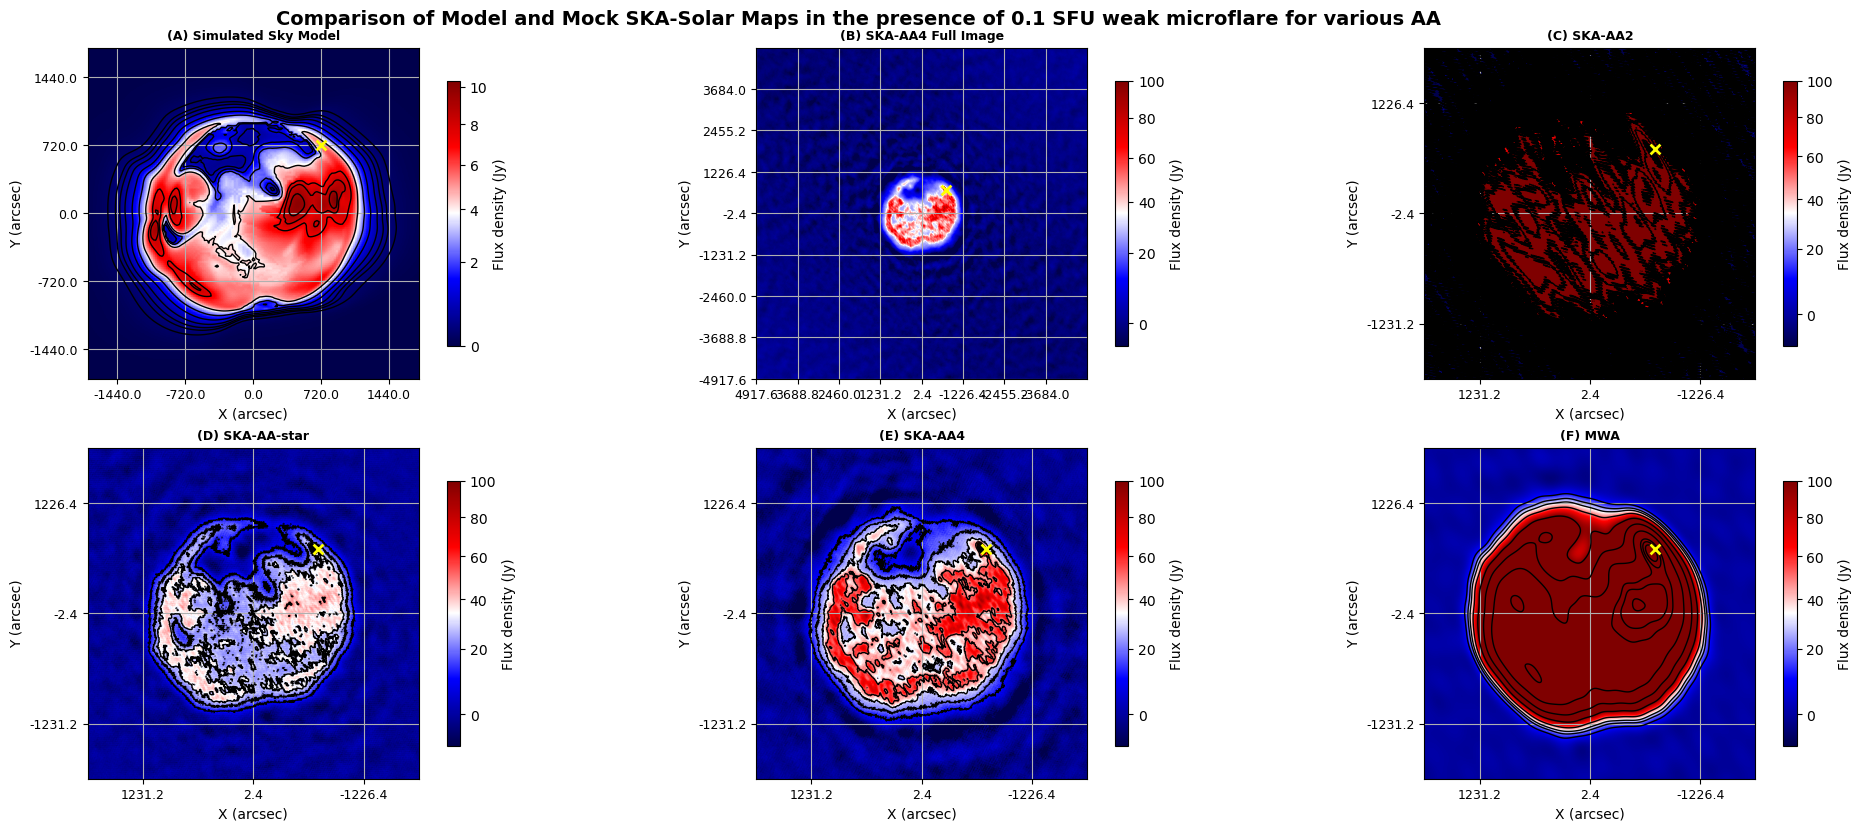

In [34]:
kernel = np.ones((10, 10))
solar_map_conv = convolve2d(solar_map_jy, kernel, mode='same', boundary='fill', fillvalue=0)
solar_map_conv = solar_map_conv / np.max(solar_map_conv) * np.max(point_flux)
mapsun_ = mapsun[0]
print(smhead1)
print(solar_map_jy.max(),mapsun_.max(),smdelt*3600,mapsun_.shape)
print(head['CDELT1']*3600,head['CRVAL1'],head['CRVAL2'])
print(head['CRPIX1'],head['CRPIX2'])
print(solar_map_jy.shape)
img_ra =  (np.arange(solar_map_jy.shape[0]) - int(solar_map_jy.shape[0]/2))*smdelt
img_dec =  (np.arange(solar_map_jy.shape[1]) - int(solar_map_jy.shape[0]/2))*smdelt
ra_arr =  (np.arange(mapsun_.shape[0]) - head['CRPIX1'])*head['CDELT1']*3600 
dec_arr =  (np.arange(mapsun_.shape[1]) - head['CRPIX2'])*head['CDELT2']*3600

#img_x_pix, img_y_pix = w.world_to_pixel_values(img_ra, img_dec);img_x_pix = int(round(img_x_pix));img_y_pix = int(round(img_y_pix))


# ----------------------------------------------------------
# Helper: Set ticks and labels
# ----------------------------------------------------------
def set_ticks_labels(ax, xarr, yarr, xstep, ystep,
                    xscale=1.0, yscale=1.0,
                    xlabel='X (arcsec)', ylabel='Y (arcsec)',
                    tick_fs=9, label_fs=10):
    ax.set_xticks(np.arange(len(xarr))[::xstep])
    ax.set_yticks(np.arange(len(yarr))[::ystep])
    ax.set_xticklabels(np.round(xarr[::xstep] * xscale, 1), fontsize=tick_fs)
    ax.set_yticklabels(np.round(yarr[::ystep] * yscale, 1), fontsize=tick_fs)
    ax.set_xlabel(xlabel, fontsize=label_fs)
    ax.set_ylabel(ylabel, fontsize=label_fs)

# ----------------------------------------------------------
# Helper: One panel plotter to avoid repetition
# ----------------------------------------------------------
def plot_panel(ax, data, title, leg, b0,b1, cmap='seismic',
               power=0.7, cont=True, vmin=None, vmax=None,
               xlabel='X (arcsec)', ylabel='Y (arcsec)',
               title_fs=9):

    im = ax.imshow(
        data, origin='lower', aspect='equal', cmap=cmap,
        norm=PowerNorm(power, vmin=vmin, vmax=vmax)
    )
    # ---- Add contour levels relative to max ----
    data_max = np.nanmax(data)
    contour_levels = [0.9, 0.8, 0.7, 0.4, 0.2, 0.1, 0.05, 0.03, 0.02,0.01][::-1]  # percentages
    contour_values = [level * data_max for level in contour_levels]
    if(cont):
        cs = ax.contour(
            data, levels=contour_values,
            colors='black', linewidths=1.0, zorder=5
        )
    ax.scatter(b0, b1, color='yellow', s=50, marker='x', linewidth=2,zorder=10)
    # Optional: label contours with percentages
    #ax.clabel(cs, inline=True, fontsize=6,
    #          fmt=lambda v: f"{int((v/data_max)*100)}%")
    # ---- Legend ----
    #proxy_patch = Patch(facecolor='none', edgecolor='black', label=leg)
    #ax.legend(handles=[proxy_patch], loc='upper right')
    # ---- Title & Labels ----
    ax.set_title(title, fontsize=title_fs, fontweight='bold')
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.grid()
    # ---- Colorbar ----
    cbar = plt.colorbar(im, ax=ax, shrink=0.8)
    cbar.set_label('Flux density (Jy)', fontsize=10)
    return ax

def zoom_center(ax, data, frac=0.5):
    """Zoom into the central region of the image using x/y limits."""
    ny, nx = data.shape
    half = (1 - frac) / 2      # for frac=0.5 → half=0.25
    ax.set_xlim(nx*half, nx*(1-half))
    ax.set_ylim(ny*half, ny*(1-half))

ny, nx = solar_map_jy.shape  # image dimensions
xmin, xmax = nx*0.25, nx*0.75
ymin, ymax = ny*0.25, ny*0.75
n0 = 50; n1 = 256-50; n2 = 2048-256*3; n3= 2048+256*3


# ----------------------------------------------------------
# Create figure
# ----------------------------------------------------------
fig, ((ax0, ax1, ax2),(ax3,ax4,ax5)) = plt.subplots(2, 3, figsize=(20,8), constrained_layout=True)

# --- Panel 1: Simulated Model ---
plot_panel(
    ax0,
    solar_map_jy ,
    title='(A) Simulated Sky Model',
    title_fs=9,
    vmin=0,
    vmax=np.nanmax(solar_map_jy),
    leg = 'Forward Map', b0 = 128+32, b1 =128+32, cont=True
)
set_ticks_labels(ax0, img_ra, img_dec, 32, 32)
ax0.set_xlim(n0, n1)
ax0.set_ylim(n0, n1)

# --- Panel 2: Reconstruction (cropped) ---
plot_panel(
    ax1,
    mapsun[3] ,
    title='(B) SKA-AA4 Full Image',
    title_fs=9,
    vmin=-3,
    vmax=np.nanmax(mapsun[3])/10,
    leg = 'AA4 Full Image', b0 = 2048+300, b1 =2038+300, cont=False
)
set_ticks_labels(ax1, ra_arr, dec_arr, 512, 512)
#ax1.set_xlim(n0, n1)
#ax1.set_ylim(n0, n1)

# --- Panel 3: Convolved Model ---
plot_panel(
    ax2,
    mapsun[1],
    title='(C) SKA-AA2',
    leg='Dynamic range:'+str(np.round(DR0[1],0)),
    vmin=-5,
    vmax=np.nanmax(mapsun[1])/10,
    title_fs=9, b0 = 2048+300, b1 =2048+300, cont=True
)
set_ticks_labels(ax2, ra_arr, dec_arr, 512, 512)
ax2.set_xlim(n2,n3)
ax2.set_ylim(n2,n3)

#--------
plot_panel(
    ax3,
    mapsun[2],
    title='(D) SKA-AA-star',
    leg='Dynamic range:'+str(np.round(DR0[2],0)),    
    vmin=-5,
    vmax=np.nanmax(mapsun[2])/10,
    title_fs=9, b0 = 2048+300, b1 =2048+300, cont=True
)
set_ticks_labels(ax3, ra_arr, dec_arr, 512, 512)
ax3.set_xlim(n2,n3)
ax3.set_ylim(n2,n3)

#----------------------------------
plot_panel(
    ax4,
    mapsun[3],
    title='(E) SKA-AA4',
    leg='Dynamic range:'+str(np.round(DR0[3],0)),    
    vmin=-5,
    vmax=np.nanmax(mapsun[3])/10,
    title_fs=9, b0 = 2048+300, b1 =2048+300, cont=True
)
set_ticks_labels(ax4, ra_arr, dec_arr, 512, 512)
ax4.set_xlim(n2,n3)
ax4.set_ylim(n2,n3)

plot_panel(
    ax5,
    mapsun[4],
    title='(F) MWA',
    leg='Dynamic range:'+str(np.round(DR0[4],0)),    
    vmin=-5,
    vmax=np.nanmax(mapsun[4])/10,
    title_fs=9, b0 = 2048+300, b1 =2048+300, cont=True
)
set_ticks_labels(ax5, ra_arr, dec_arr, 512, 512)
ax5.set_xlim(n2,n3)
ax5.set_ylim(n2,n3)
# --- Figure Title ---
fig.suptitle('Comparison of Model and Mock SKA-Solar Maps in the presence of 0.1 SFU weak microflare for various AA',
            fontsize=14, fontweight='bold', y=1.02)
fig.savefig(path+'/analysis_plot0.png',dpi=100,bbox_inches="tight")
plt.show()

In [48]:
sys.exit()
print(solar_map_jy.shape, solar_map_conv.shape, mapsun.shape)
img_ra_arr = (np.arange(mapsun.shape[0])-int(mapsun.shape[0]/2))*head['CDELT1']*3600
f,(ax0,ax1,ax2) = plt.subplots(3,1)
ax0.plot(ra_arr,solar_map_jy[1024])
ax0.plot(img_ra_arr,mapsun[4096]/100)
ax2.plot(ra_arr,solar_map_conv[1024]*np.nanmax(solar_map))
ax1.set_xlim(ra_arr[0],ra_arr[-1])
plt.show()


SystemExit: 

/home/rohit/miniconda3/envs/karabo/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3558: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


## Simulation of Mark's Model ##

0.004209261352323213
0.26482758620689656


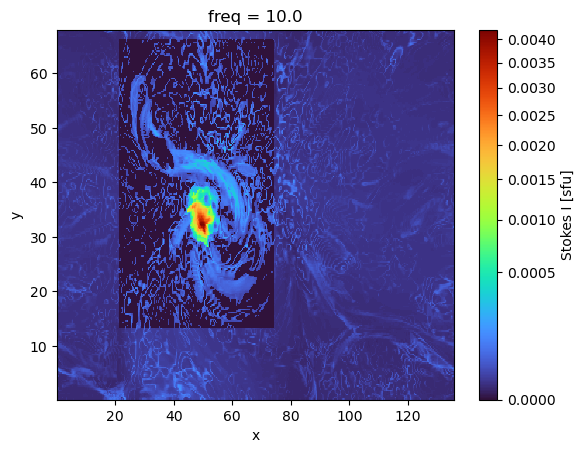

In [ ]:
# Step-1 Analyse initial Skymodel

#sc2: Mark's Model 
#telescope_path = '/media/rohit/sdata/ska-solar-files/meerkat.tm'
telescope_path = '/data/rohit/skao_repo/ska1mid.tm'
#telescope_path = '/data/rohit/skao_repo/ska-mid-AAstar.tm'
#telescope_path = '/data/rohit/skao_repo/ska-mid-AA2.tm'
#telescope_path = '/data/rohit/skao_repo/ska-mid-AA1.tm'
#telescope_path = '/media/rohit/sdata/ska-solar-files/mwa.phase1.tm'
#telescope_path = '/data/rohit/skao_repo/ska1low.tm'
telescope_name= 'ska1mid'
hour_=0
minutes_=1
noise_enable_ = False
enable_array_beam=False
skao_repo_tel_path = '/data/rohit/skao_repo/'
#tel_all = get_telescope(skao_repo_tel_path) # 0 is SKA, and 1 is SKA-precursor
telescope_list = ['skalow','skamid','mwa','meerkat']
ska_aa_list = ['AA0.5','AA1','AA2','AAs','Full']
mid_bands=['1','3']
nt=1; tel = telescope_list[nt] # Put in your telescope in `tel`
ds = xr.load_dataset('/data/rohit/solar-sky-models/mark_skymodels/muram_530000_los0_grff.ncdf')
smdata10 = ds['Stokes I'].sel(freq=10, method='nearest').T.data[50:250,80:280]
smdata5 = ds['Stokes I'].sel(freq=5, method='nearest').T.data[50:250,80:280]
print(smdata10.max())
smdata10[smdata10<2.e-5] = 0
smdata5[smdata5<1.e-5] = 0


ds['Stokes I'].sel(freq=10, method='nearest').T.plot(norm=PowerNorm(0.5), cmap='turbo')
dsx=ds['x']
res_sm2=dsx.data[1]-dsx.data[0] # in arcsec
print(res_sm2)

Number of Baselines: 19306
Maximum Baseline 157396.94486666212
[3.93142586 1.96571293 1.31047529 0.98285646 0.78628517 0.65523764
 0.56163227 0.49142823 0.4368251  0.39314259 0.35740235 0.32761882
 0.30241737 0.28081613 0.26209506 0.24571412 0.23126034 0.21841255
 0.20691715]


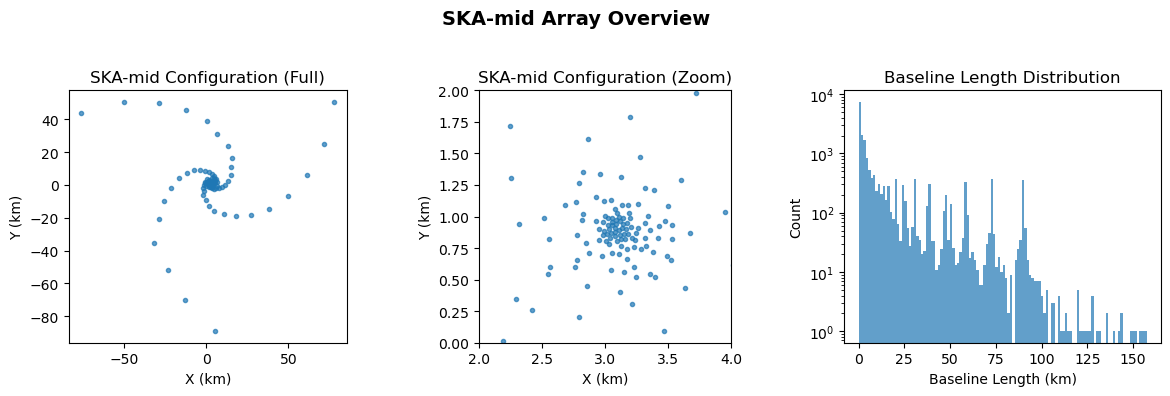

In [ ]:
# Step-2 Analyse Telescope Model 
layout=np.loadtxt(telescope_path+'/layout.txt')
nant=len(layout)
nb=int(nant*(nant-1)*0.5)
print('Number of Baselines:',nb)
base_length=[0]*nb
k=0
for i in range(nant):
    for j in range(i,nant):
        if(i!=j):
            base_length[k] = np.sqrt((layout[i][0]-layout[j][0])**2 + (layout[i][1]-layout[j][1])**2)
            k=k+1
base_length=np.array(base_length)
print('Maximum Baseline',base_length.max())
#----------------------------
freq_list = np.arange(1,20)*100 # in MHz
beamsize_arr = 3.e8/base_length.max()/(freq_list*1.e6)
beamsize_arr_arcsec = beamsize_arr*180/np.pi*3600
print(beamsize_arr_arcsec)
f,ax=plt.subplots(1,1)
ax.plot(freq_list,beamsize_arr_arcsec,'o-')
ax.set_xlabel('Frequency (MHz)')
ax.set_ylabel('Max. Resolution (arcsec)')
ax.set_title('SKA-mid')
#ax.set_yscale('log')
plt.close()


#-----------------------------------------------------
fig, (ax0, ax1, ax2) = plt.subplots(1, 3, figsize=(12, 4))
# --- Panel 1: Full SKA-mid layout ---
for ax in [ax0, ax1]:
    ax.plot(layout[:, 0] / 1e3, layout[:, 1] / 1e3, 'o', ms=3, alpha=0.7)
    ax.set_xlabel('X (km)')
    ax.set_ylabel('Y (km)')
    ax.set_aspect('equal')
ax0.set_title('SKA-mid Configuration (Full)')
ax1.set_title('SKA-mid Configuration (Zoom)')
ax1.set_xlim(2, 4)
ax1.set_ylim(0, 2)
# --- Panel 3: Baseline length distribution ---
ax2.hist(base_length / 1e3, bins=120, color='tab:blue', alpha=0.7)
ax2.set_xlabel('Baseline Length (km)')
ax2.set_ylabel('Count')
ax2.set_yscale('log')
ax2.set_title('Baseline Length Distribution')
# Improve layout and appearance
fig.suptitle('SKA-mid Array Overview', fontsize=14, fontweight='bold')
fig.tight_layout(rect=[0, 0, 1, 0.95])


In [ ]:
# Step-3 Generate Karabo Skymodel

path = '/data/rohit/ska-solar-sim-repo-paper/sc2/'

ra_sun_center=249.141666667;dec_sun_center=21.986 #16 34 34.52 -21 59 09.7
#skymodel_cellsize=22.5 # in arcsec
#-------- Define Image Parameters
#npix_per_beam = 3


i=1
smdata=[smdata5,smdata10]
solar_map=smdata[i]
freq_list = [5,10]
start_frequency_hz_ = freq_list[i]*1.e9
print("Frequency (GHz): ",start_frequency_hz_)
ms_filename = path+"solar_"+"freq_"+str(int(freq_list[i]))+'_'+telescope_name+".ms"
vis_filename = path+"solar_"+"freq_"+str(int(freq_list[i]))+'_'+telescope_name+".vis"
solar_map_jy=solar_map*1.e4#/np.nanmax(solar_map)*20*1.e4*(start_frequency_hz_/2.4e8)**1
ra_sun_center=249.141666667;dec_sun_center=21.986 #16 34 34.52 -21 59 09.7
ra_arr=(np.arange(solar_map_jy.shape[0])-int(solar_map_jy.shape[0]/2))
dec_arr=(np.arange(solar_map_jy.shape[1])-int(solar_map_jy.shape[1]/2))
ra_grid,dec_grid=np.meshgrid(ra_arr*res_sm2/3600.,dec_arr*res_sm2/3600.)
ra_grid=ra_grid+ra_sun_center;dec_grid=dec_grid+dec_sun_center
sky_model_ra=ra_grid.flatten();sky_model_dec=dec_grid.flatten();flux=solar_map_jy.flatten()
print(sky_model_dec.shape,flux.shape,sky_model_ra,solar_map_jy.max())

NameError: name 'smdata5' is not defined

In [ ]:
# Step-4 Do Observation
#-----------
ms_filename = path+"solar_"+"freq_"+str(int(freq_list[i]))+'GHz_'+telescope_name+".ms"
vis_filename = path+"solar_"+"freq_"+str(int(freq_list[i]))+'GHz_'+telescope_name+".vis"# Simulation starts 
sky = SkyModel()
sky_data = np.array([sky_model_ra, sky_model_dec, flux,np.zeros(len(flux)), \
                    np.zeros(len(flux)),np.zeros(len(flux)), np.zeros(len(flux)),\
                    np.zeros(len(flux)), np.zeros(len(flux)),np.zeros(len(flux)), np.zeros(len(flux)),np.zeros(len(flux))]).T
#sky_data=sky_data[0:16000,:]
sky.add_point_sources(sky_data)
dtime=datetime(2000, 1, 1, 10, 0, 00, 0) # MeerKAT/ SKA-mid
backend=SimulatorBackend.OSKAR
telescope=Telescope.read_OSKAR_tm_file(telescope_path)
telescope.read_OSKAR_tm_file(telescope_path)
noise_enable_ = False
channel_bandwidth_hz_ = 10.e3
time_average_sec_ = 8
hour_ =0;minutes_=0;seconds_=8
nchan = 100
ntchan = 1
simulation = InterferometerSimulation(vis_path=vis_filename, ms_file_path=ms_filename,
    channel_bandwidth_hz=channel_bandwidth_hz_, time_average_sec=time_average_sec_, noise_enable=noise_enable_, use_gpus=True,
    noise_seed="time", noise_freq="Range", noise_rms="Range", 
    noise_start_freq=1.e9, noise_inc_freq=1.e8, noise_number_freq=24, 
    noise_rms_start=0, noise_rms_end=0, enable_numerical_beam=enable_array_beam,
    enable_array_beam=enable_array_beam) 
observation = Observation(mode='Tracking',phase_centre_ra_deg=ra_sun_center, start_date_and_time=dtime, 
    length=timedelta(hours=hour_, minutes=minutes_, seconds=seconds_, milliseconds=0), 
    phase_centre_dec_deg=dec_sun_center, number_of_time_steps=ntchan, 
    start_frequency_hz=start_frequency_hz_, frequency_increment_hz=1, 
    number_of_channels=nchan ) 
visibility = simulation.run_simulation(telescope, sky, observation, backend=backend)
do_oskar_image = 0
if(do_oskar_image):
    dirty_imager = OskarDirtyImager(
        OskarDirtyImagerConfig(
            imaging_npixel=imgsize,
            imaging_cellsize=cellsize_rad,
        ))
    dirty_oskar_img = path+"solar_"+"freq_"+str(int(freq_list[i]))+'GHz_'+telescope_name+"_oskar.fits"
    dirty_image = dirty_imager.create_dirty_image(visibility,output_fits_path=dirty_oskar_img)


W|                                                                   
W|== WARNING: No GPU capability available.
W|                                                                   
Saved visibility to /data/rohit/ska-solar-sim-repo-paper/sc2/solar_freq_10GHz_ska1mid.vis


In [ ]:
# Step-5 Do WSclean
imager_str = 'wsclean'
maxuv = 90000 # in lambda units
minuv = 1 # in lambda units
wi=0
for wi in range(4):
    weight0 = ['-weight natural', '-weight uniform','-super-weight 5','-super-weight 8']
    weight_list = ['w-nat','w-uni','w-suni5','w-suni8']
    weight=weight0[wi]
    weight_str=weight_list[wi]
    #----------------
    niter=5000
    dirty_wsclean_img = path+"solar_"+"freq_"+str(int(freq_list[i]))+'GHz_'+telescope_name+'_'+weight_str
    print(dirty_wsclean_img)
    imgsize=4096
    cellsize_arcsec=res_sm2/5 #beam_size_arcsec/npix_per_beam
    cellsize_rad=cellsize_arcsec/3600*np.pi/180 # in rad
    nchan_clean = 1
    print('Cellsize:',cellsize_arcsec,'arcsec')
    print('Cellsize:',cellsize_rad,'rad')
    print('Field of View (deg):',imgsize*cellsize_arcsec/3600.)
    img_cmd = 'wsclean \
            -size '+str(imgsize)+' '+str(imgsize)+' \
            -name '+dirty_wsclean_img+' \
            -scale '+str(cellsize_rad)+'rad -niter '+str(niter)+' -mgain 0.8 \
            '+str(weight)+'\
            -maxuv-l '+str(maxuv)+' -minuv-l '+str(minuv)+'\
            -channels-out '+str(nchan_clean)+' '+ms_filename
    print(img_cmd)
    try:
        restored = imager_wsclean.create_image_custom_command(command=img_cmd)
    except:
        pass # doing nothing on exception  
    mapsun05,head = fits.getdata(dirty_wsclean_img+'-dirty.fits',header=True)
    mapsun05 =  mapsun05[0][0]/np.max(mapsun05)*np.max(smdata5)
    print(head['CDELT1']*3600,head['CUNIT1'])

/data/rohit/ska-solar-sim-repo-paper/sc2/solar_freq_10GHz_ska1mid_w-nat
Cellsize: 0.05296551724137931 arcsec
Cellsize: 2.5678407385663704e-07 rad
Field of View (deg): 0.06026298850574713
wsclean             -size 4096 4096             -name /data/rohit/ska-solar-sim-repo-paper/sc2/solar_freq_10GHz_ska1mid_w-nat             -scale 2.5678407385663704e-07rad -niter 5000 -mgain 0.8             -weight natural            -maxuv-l 90000 -minuv-l 1            -channels-out 1 /data/rohit/ska-solar-sim-repo-paper/sc2/solar_freq_10GHz_ska1mid.ms
Creating /tmp/karabo-STM-rohit-TRnaSBphUX/WSClean-custom-A5setgNok9 for Disk cache for WSClean custom command images
WSClean command: [cd /tmp/karabo-STM-rohit-TRnaSBphUX/WSClean-custom-A5setgNok9 && OPENBLAS_NUM_THREADS=1 wsclean             -size 4096 4096             -name /data/rohit/ska-solar-sim-repo-paper/sc2/solar_freq_10GHz_ska1mid_w-nat             -scale 2.5678407385663704e-07rad -niter 5000 -mgain 0.8             -weight natural            -m

['/data/rohit/ska-solar-sim-repo-paper/sc2/solar_freq_5GHz_ska1mid_w-nat-image.fits', '/data/rohit/ska-solar-sim-repo-paper/sc2/solar_freq_5GHz_ska1mid_w-suni5-image.fits', '/data/rohit/ska-solar-sim-repo-paper/sc2/solar_freq_5GHz_ska1mid_w-suni8-image.fits', '/data/rohit/ska-solar-sim-repo-paper/sc2/solar_freq_5GHz_ska1mid_w-uni-image.fits']
(200, 200) /data/rohit/ska-solar-sim-repo-paper/sc2/solar_freq_5GHz_ska1mid_w-nat-image.fits
0.05296551724137924
(1230, 1230)
(1230, 1230)


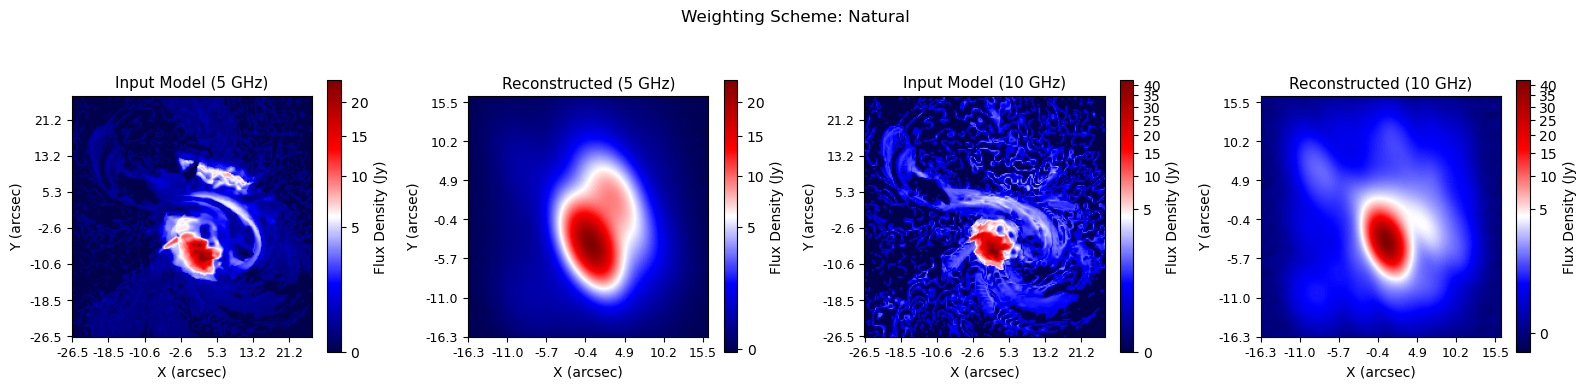

(200, 200) /data/rohit/ska-solar-sim-repo-paper/sc2/solar_freq_5GHz_ska1mid_w-suni5-image.fits
0.05296551724137924
(1230, 1230)
(1230, 1230)


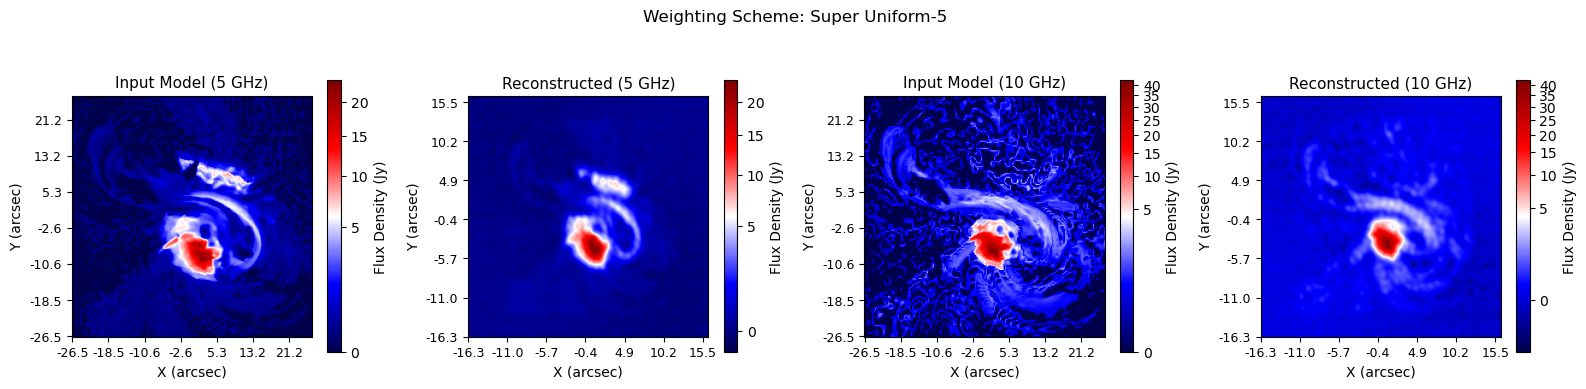

(200, 200) /data/rohit/ska-solar-sim-repo-paper/sc2/solar_freq_5GHz_ska1mid_w-suni8-image.fits
0.05296551724137924
(1230, 1230)
(1230, 1230)


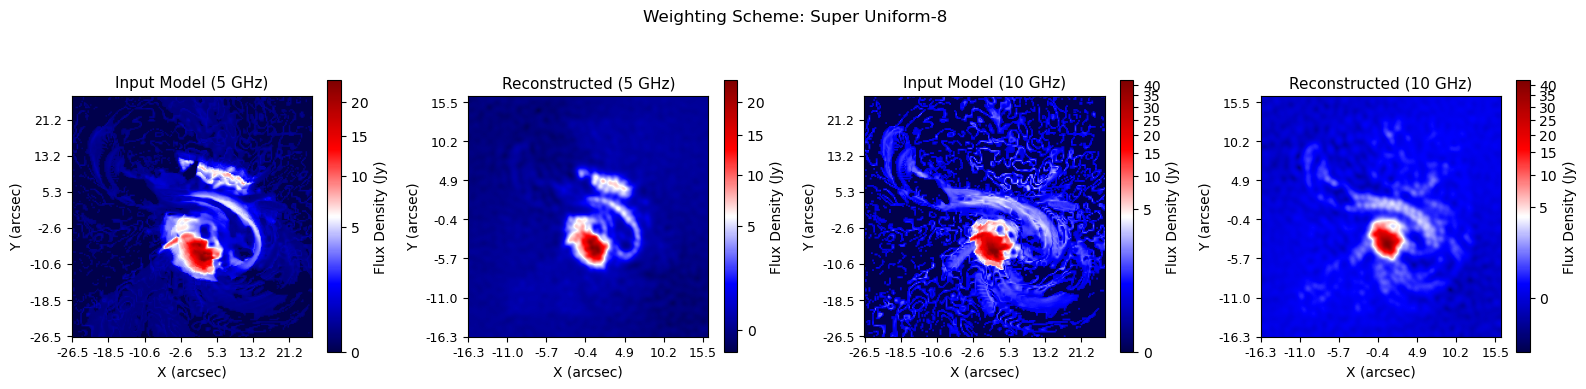

(200, 200) /data/rohit/ska-solar-sim-repo-paper/sc2/solar_freq_5GHz_ska1mid_w-uni-image.fits
0.05296551724137924
(1230, 1230)
(1230, 1230)


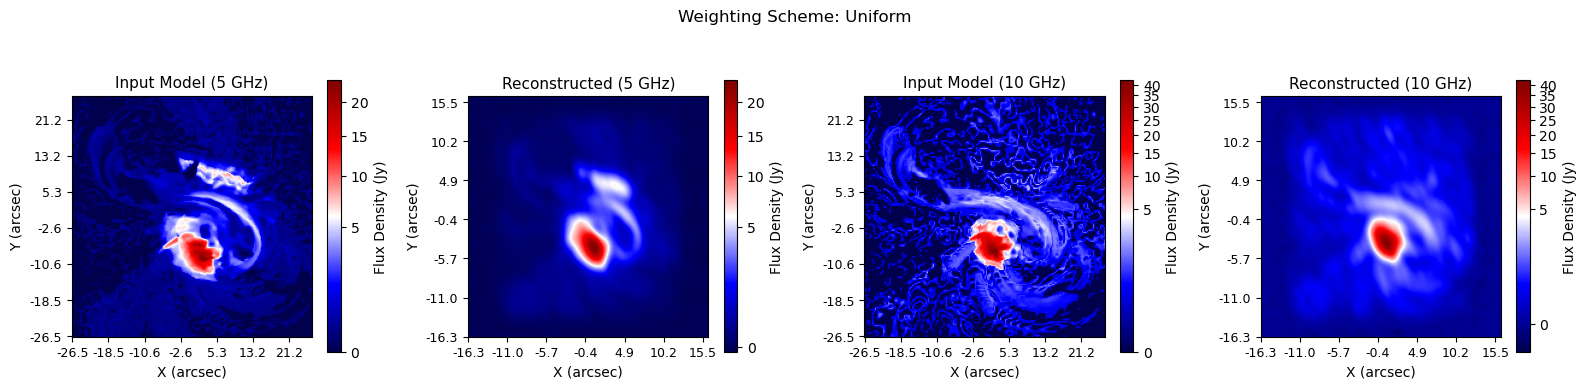

In [ ]:
def set_ticks_labels(ax, xarr, yarr, xstep, ystep, xscale=1.0, yscale=1.0, xlabel='X (arcsec)', ylabel='Y (arcsec)'):
    """Helper function to set ticks and labels"""
    ax.set_xticks(np.arange(len(xarr))[::xstep])
    ax.set_yticks(np.arange(len(yarr))[::ystep])
    ax.set_xticklabels(np.round(xarr[::xstep] * xscale, 1), fontsize=tick_fontsize)
    ax.set_yticklabels(np.round(yarr[::ystep] * yscale, 1), fontsize=tick_fontsize)
    ax.set_xlabel(xlabel, fontsize=label_fontsize)
    ax.set_ylabel(ylabel, fontsize=label_fontsize)

img_list0 = sorted(glob.glob('/data/rohit/ska-solar-sim-repo-paper/sc2/solar*5GHz*image.fits'))
img_list1 = sorted(glob.glob('/data/rohit/ska-solar-sim-repo-paper/sc2/solar*10GHz*image.fits'))
print(img_list0)

def get_img(img_list0,cutoff,ds):
    wsclean_img0=img_list0
    img_freq0 = wsclean_img0.split('_')[2]
    img_freq_int = int(img_freq0.split('G')[0])
    sm_img=ds['Stokes I'].sel(freq=img_freq_int, method='nearest').T.data[50:250,80:280]
    sm_img[sm_img<cutoff] = 0
    return sm_img
weight_str = ['Natural','Super Uniform-5','Super Uniform-8','Uniform']
for i in range(len(img_list0)):
    sm_img0 = get_img(img_list0[i],1.e-5,ds)
    sm_img1 = get_img(img_list1[i],2.e-5,ds)
    print(sm_img0.shape,img_list0[i])
    mapsun05,head = fits.getdata(img_list0[i],header=True)
    mapsun05 =  mapsun05[0][0]/np.max(mapsun05)*np.max(sm_img0)
    print(head['CDELT2']*3600)
    img_ra =  (np.arange(mapsun05.shape[0])-int(mapsun05.shape[0]/2))*head['CDELT1']*3600
    img_dec = (np.arange(mapsun05.shape[1])-int(mapsun05.shape[1]/2))*head['CDELT2']*3600
    mapsun10 = fits.getdata(img_list1[i])[0][0]
    mapsun10 =  mapsun10/np.max(mapsun10)*np.max(sm_img1)
    ra_arr=(np.arange(sm_img0.shape[0])-int(sm_img0.shape[0]/2))
    dec_arr=(np.arange(sm_img0.shape[1])-int(sm_img0.shape[1]/2))
    # Plot the results 
    y=ds['Stokes I'].sel(freq=5, method='nearest').T
    # --- Create figure and axes ---
    fig, axes = plt.subplots(1, 4, figsize=(16, 4))
    (ax0, ax1, ax2, ax3) = axes
    # --- Common style settings ---
    tick_fontsize = 9
    label_fontsize = 10
    title_fontsize = 11
    # --- Plot 5 GHz Input Model ---
    im0 = ax0.imshow(sm_img0 * 1e4, aspect='equal', origin='lower', cmap='seismic',norm=PowerNorm(0.5))
    ax0.set_title('Input Model (5 GHz)', fontsize=title_fontsize)
    set_ticks_labels(ax0, ra_arr, dec_arr, 30, 30, res_sm2, res_sm2)
    cbar0 = fig.colorbar(im0, ax=ax0, shrink=0.8)
    cbar0.set_label('Flux Density (Jy)', fontsize=label_fontsize)
    # --- Plot 5 GHz Reconstructed ---
    scale_num=0.7
    y1 = mapsun05[:, ::-1] * 1e4
    ny, nx = y1.shape
    dy, dx = int(ny * scale_num * 0.5), int(nx * scale_num * 0.5)
    y1 = y1[dy:ny - dy, dx:nx - dx]
    ra_ticks = img_ra[dx:nx - dx][::-1]/2
    dec_ticks = img_dec[dy:ny - dy]/2
    print(y1.shape)
    im1 = ax1.imshow(y1, aspect='equal', origin='lower', cmap='seismic',norm=PowerNorm(0.5))
    ax1.set_title('Reconstructed (5 GHz)', fontsize=title_fontsize)
    set_ticks_labels(ax1, ra_ticks, dec_ticks, 200, 200, xscale=1,yscale=1)
    cbar1 = fig.colorbar(im1, ax=ax1, shrink=0.8)
    cbar1.set_label('Flux Density (Jy)', fontsize=label_fontsize)
    # --- Plot XX GHz Input Model ---
    im2 = ax2.imshow(sm_img1 * 1e4, aspect='equal', origin='lower', cmap='seismic',norm=PowerNorm(0.3))
    ax2.set_title('Input Model (10 GHz)', fontsize=title_fontsize)
    set_ticks_labels(ax2, ra_arr, dec_arr, 30, 30, res_sm2, res_sm2)
    cbar2 = fig.colorbar(im2, ax=ax2, shrink=0.8)
    cbar2.set_label('Flux Density (Jy)', fontsize=label_fontsize)
    # --- Plot XX GHz Reconstructed ---
    scale_num=0.7
    y1 = mapsun10[:, ::-1] * 1e4
    ny, nx = y1.shape
    dy, dx = int(ny * scale_num * 0.5), int(nx * scale_num * 0.5)
    y1 = y1[dy:ny - dy, dx:nx - dx]
    ra_ticks = img_ra[dx:nx - dx][::-1]/2
    dec_ticks = img_dec[dy:ny - dy]/2
    print(y1.shape)
    im3 = ax3.imshow(y1, aspect='equal', origin='lower', cmap='seismic',norm=PowerNorm(0.3))
    ax3.set_title('Reconstructed (10 GHz)', fontsize=title_fontsize)
    set_ticks_labels(ax3, ra_ticks, dec_ticks, 200, 200, xscale=1,yscale=1)
    cbar1 = fig.colorbar(im3, ax=ax3, shrink=0.8)
    cbar1.set_label('Flux Density (Jy)', fontsize=label_fontsize)
    # --- Improve layout ---
    plt.suptitle('Weighting Scheme: '+weight_str[i])
    plt.tight_layout()
    plt.savefig(img_list0[i]+'.png')
    plt.show()